In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import plotly.express as px
from DBSCANSupport import DBSCANSupport
#from LocalPath import LOCALPATH
from sklearn.cluster import DBSCAN
from pathlib import Path

In [4]:
grav_dat = Path('data') / 'test_curv_32.highpass.csv'
grav = pd.read_csv(grav_dat, names=['Longitude', 'Latitude', 'Intensity'], header=0)
grav = grav[['Longitude', 'Latitude', 'Intensity']]
train_bounds = (-4.525, -2.38, -95.85833, -93.00833)

In [3]:
Z = DBSCANSupport.formatData(grav, 'Intensity')
data = Z

/Users/martinhawks/Code/Git_repos/stable_seamount/seamount_picking/code/_SeamountSupport.py:304: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["TrueSeamount"] = np.zeros(data.shape[0])


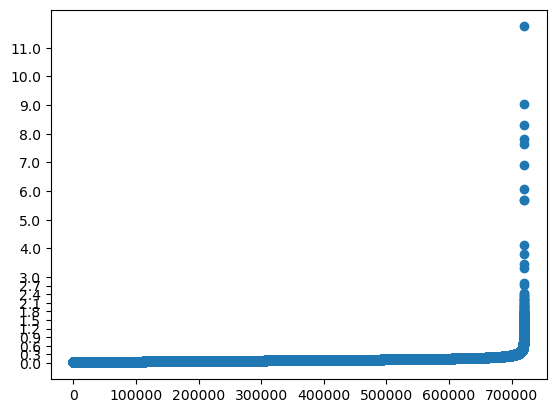

In [4]:
## Elbow test
from sklearn.neighbors import NearestNeighbors
from matplotlib import pyplot as plt
neighbors = NearestNeighbors(n_neighbors=20)
neighbors_fit = neighbors.fit(data)
distances, indices = neighbors_fit.kneighbors(data)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
elbow = plt.scatter(x=range(0, len(distances)), y=distances)#.show()
ticks = np.arange(3, 12, step=1)
startt = np.arange(0, 3, step=0.3)
ticks = np.concatenate((startt, ticks))
plt.yticks(ticks);

In [5]:
test_eps = np.linspace(0.01, 0.6, 20)
test_samp = np.arange(2, 15)
DBModel_test = DBSCANSupport(Path('data') / "sample_mask.txt.xlsx", train_zone=train_bounds)
DBModel_test.addTrainingData(data)

In [6]:
score, params, data_out, out  = DBModel_test.gridSearch(test_eps, test_samp, verbose=True)

0.01 and 2 produced too few {-1} clusters
0.01 and 3 produced too few {-1} clusters
0.01 and 4 produced too few {-1} clusters
0.01 and 5 produced too few {-1} clusters
0.01 and 6 produced too few {-1} clusters
0.01 and 7 produced too few {-1} clusters
0.01 and 8 produced too few {-1} clusters
0.01 and 9 produced too few {-1} clusters
0.01 and 10 produced too few {-1} clusters
0.01 and 11 produced too few {-1} clusters
0.01 and 12 produced too few {-1} clusters
0.01 and 13 produced too few {-1} clusters
0.01 and 14 produced too few {-1} clusters
Score for 0.04105263157894737 and 2 is 14.413317613161043 with 2237 clusters
Score for 0.04105263157894737 and 3 is 8.897535948709063 with 595 clusters
Score for 0.04105263157894737 and 4 is 6.2478428369460275 with 145 clusters
Score for 0.04105263157894737 and 5 is 5.315500777637575 with 29 clusters
Score for 0.04105263157894737 and 6 is 5.062272070171081 with 3 clusters
0.04105263157894737 and 7 produced too few {-1} clusters
0.041052631578947

In [7]:
dfout = pd.DataFrame(data_out, columns=["Lat", "Lon", "Label", "Intensity", "TrueLabel"])
seamount_points = DBModel_test.getSeamountPoints()
df_labeled = dfout[(dfout["Label"] != dfout["Label"].mode().iloc[0])]

In [8]:
test_zone=train_bounds
seamounts = pd.read_excel(Path('data') / "sample_mask.txt.xlsx", \
                              sheet_name="new mask")
seamounts = seamounts.drop(columns=["VGG Height", "Radius", "base_depth", "-",
                                        "Name", "Charted", "surface_depth"])
seamounts = seamounts[(seamounts["Latitude"] >= test_zone[0]) & (seamounts["Latitude"] <= test_zone[1]) &
                          (seamounts["Longitude"] >= test_zone[2]) & (seamounts["Longitude"] <= test_zone[3])]
seamounts = seamounts.to_numpy()

In [9]:
fig = px.scatter(x=seamounts[:, 0], y=seamounts[:, 1], width=1000, height=500)
fig.add_trace(px.scatter(df_labeled, x="Lon", y="Lat", color="TrueLabel",).data[0])
fig.update_xaxes(
    scaleanchor="y",
    scaleratio=1,
  )
fig.update_layout(title="Model labels")
fig.show()

In [10]:
fig2 = px.scatter(dfout, x="Lon", y="Lat", color="TrueLabel", width=1000, height=500)
fig2.update_xaxes(
    scaleanchor="y",
    scaleratio=1,
  )
fig2.update_layout(title="True Labels")

In [11]:
out_dir = Path('out')
with open(out_dir / "best.txt", "r") as f:
    lines = f.read()
    lines = lines.split("\n")
    scores = [line for line in lines if "Score" in line]
    scores = [float(score.split(": ")[-1]) for score in scores]
    best = np.argmax(scores)


In [12]:
with open(Path('out') / "best.txt", "a") as f:
    f.write("Score: " + str(score) + "\n")
    f.write("Params: " + str(params) + "\n")
    f.write("Used Outliers: " + str(out) + "\n")
if score < best:
    DBModel_test.matchPoints().to_csv(out_dir / "matched.csv", index=False)
    dfout.to_csv(out_dir / "labels.csv", index=False)
